In [1]:
import json
import sys
from pathlib import Path

import cv2
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

src_path = Path.cwd().parent
print(src_path)
sys.path.append(str(src_path))

from src.config import config
from src.dto import Dto


def load_image_json_data(filename: str) -> Dto:
    try:
        with open(filename, "r") as file:
            data = json.load(file)
        return Dto(**data)
    except Exception as e:
        print(f"Failed to load JSON data from {filename}: {e}")
        return None

json_files_directory:str = config.output_path
print(json_files_directory)
json_files = [f for f in Path(json_files_directory).rglob("*.json")]
print(json_files)
print(f"Found {len(json_files)} JSON files in {json_files_directory}")

data:list[Dto] = []
for file in json_files:
    dto = load_image_json_data(file)
    if dto is not None:
        data.append(dto)
print(f"Loaded {len(data)} DTOs")


e:\DATA\_Data_\EDU\StudiaElektryczny\SEM9\proj_badawczy\watermarking
Config: {'cores': 1, 'dataset_path': 'C:/Users/Vectro/.cache/kagglehub/datasets/felicepollano/watermarked-not-watermarked-images/versions/1/wm-nowm/train/no-watermark', 'output_path': 'D:\\Data\\Python\\proj_badawczy_2024_adam_4', 'default_watermark': 'test', 'logger': <Logger.NO: 'NO'>, 'device': 'cuda'}
D:\Data\Python\proj_badawczy_2024_adam_4
[WindowsPath('D:/Data/Python/proj_badawczy_2024_adam_4/black-and-white-people-bar-men.jpg.json'), WindowsPath('D:/Data/Python/proj_badawczy_2024_adam_4/cat-animals-cats-portrait-of-cat.jpg.json'), WindowsPath('D:/Data/Python/proj_badawczy_2024_adam_4/goose-bird-white-water-bird-46176.jpeg.json'), WindowsPath('D:/Data/Python/proj_badawczy_2024_adam_4/julius-caesar-rome-roman-empire-615344.jpeg.json'), WindowsPath('D:/Data/Python/proj_badawczy_2024_adam_4/jumping-cute-playing-animals.jpg.json'), WindowsPath('D:/Data/Python/proj_badawczy_2024_adam_4/pexels-photo-1018805.jpeg.json

In [7]:
"""
class ImageMetricsModel(BaseModel):
    PSNR: float
    SSIM_RGB: float
    SSIM_Greyscale: float
    Bit_Error_Rate: float
    Mean_Squared_Error: float
    Entropy: float
    Average_Pixel_Error: float
    QualiCLIP_original: float
    QualiCLIP_watermarked: float
    LPIPS_Loss: float | None


class DtoLog(BaseModel):
    filepath: str
    watermarked_analysis_results: ImageMetricsModel
    watermark_method: str
    attack_method: str
    encoding_time: float
    decoding_time: float


class DecodingMetricsModel(BaseModel):
    Correlation_Coefficient: float | None
    Normalized_Correlation_Coefficient: float | None
    Bit_Error_Rate: float
    Mean_Squared_Error: float


class DtoDecode(BaseModel):
    decoded_watermark: str | None  # TODO change to bytes?
    decoding_time: float | None
    decoding_metrics: DecodingMetricsModel | None


class DtoAttack(BaseModel):
    name: str
    attacking_time: float | None
    decoding_results: DtoDecode
    analysis_results: ImageMetricsModel | None


class DtoWatermark(BaseModel):
    name: str
    encoding_time: float
    decoding_results: DtoDecode
    analysis_results: ImageMetricsModel | None
    attacks: list[DtoAttack] = []


class Dto(BaseModel):
    filepath: str
    watermark: str
    watermarks: list[DtoWatermark] = []

"""

watermark_algorithms = [w.name for w in data[0].watermarks]
watermark_algorithms_colors = dict(
    zip(watermark_algorithms, sns.color_palette("husl", len(watermark_algorithms)))
)
print(watermark_algorithms_colors)


def scatter_plot_for_each_attack(
    func_get_x,
    func_get_y,
    title: str,
    xlabel: str,
    ylabel: str,
    y_lower_better: bool = True,
    *,
    log_x_scale: bool = False,
    log_y_scale: bool = False,
    y_scale_percent: bool = False,
    add_trendlines: bool = False,
    func_pick_point: callable = None,
    default_error_y_value: float = None,
    disable_legend: bool = False
):
    failed, total = 0, 0
    ys = {}
    xs = {}
    for dto in data:
        for watermark in dto.watermarks:
            for attack in watermark.attacks:
                if attack.decoding_results is not None:
                    _x = func_get_x(dto, watermark, attack)
                    try:
                        if func_pick_point is not None:
                            if not func_pick_point(dto, watermark, attack):
                                continue
                        total += 1
                        if watermark.name not in ys:
                            ys[watermark.name] = []
                        if watermark.name not in xs:
                            xs[watermark.name] = []
                        _y = func_get_y(dto, watermark, attack)
                        ys[watermark.name].append(_y)
                        xs[watermark.name].append(_x)
                    except Exception as e:
                        # print(f"Failed to get data for {watermark.name} {attack.name}: {e}")
                        failed += 1
                        if default_error_y_value is not None:
                            if watermark.name not in ys:
                                ys[watermark.name] = []
                            if watermark.name not in xs:
                                xs[watermark.name] = []
                            ys[watermark.name].append(default_error_y_value)
                            xs[watermark.name].append(_x)
                        continue
    plt.figure()
    for watermark in ys:
        plt.scatter(
            xs[watermark],
            ys[watermark],
            label=watermark.replace("Watermarker", "").replace("Attacker", ""), # TODO FIX THIS
            color=watermark_algorithms_colors[watermark],
            alpha=0.5,
            marker="o",
            s=5,
        )
    if add_trendlines: #plot trendlines on plot
        for watermark in ys:
            sns.regplot(
                x=xs[watermark],
                y=ys[watermark],
                scatter=False,
                color=watermark_algorithms_colors[watermark],
            )

    plt.xlabel(xlabel)
    plt.ylabel(
        ylabel + (" (lower is better)" if y_lower_better else " (higher is better)")
    )
    failed_percentage = round(failed / total * 100, 1)
    plt.title(title + " " + f"({failed_percentage}% of {total} failed to plot)")
    if log_y_scale:
        plt.yscale("log")
    if log_x_scale:
        plt.xscale("log")
    # set y scale to percents
    if y_scale_percent:
        plt.gca().set_yticklabels(
            ["{:.0f}%".format(y * 100) for y in plt.gca().get_yticks()]
        )
    if not disable_legend:
        plt.legend()
    plt.show()


def box_plot_for_each_attack(
    func_get_x,
    func_get_y,
    title: str,
    xlabel: str,
    ylabel: str,
    y_lower_better: bool = True,
    *,
    log_x_scale: bool = False,
    log_y_scale: bool = False,
    y_scale_percent: bool = False,
    func_pick_point: callable = None,
    default_error_y_value: float = None,
):
    failed, total = 0, 0
    ys = {}
    for dto in data:
        for watermark in dto.watermarks:
            for attack in watermark.attacks:
                if attack.decoding_results is not None:
                    _x = func_get_x(dto, watermark, attack)
                    try:
                        if func_pick_point is not None:
                            if not func_pick_point(dto, watermark, attack):
                                continue
                        total += 1
                        if _x not in ys:
                            ys[_x] = []
                        _y = func_get_y(dto, watermark, attack)
                        ys[_x].append(_y)
                    except Exception as e:
                        # print(f"Failed to get data for {watermark.name} {attack.name}: {e}")
                        if default_error_y_value is not None:
                            if _x not in ys:
                                ys[_x] = []
                            ys[_x].append(default_error_y_value)
                        failed += 1
                        continue
    plt.figure()
    plt.boxplot(
        [ys[key] for key in ys],
        tick_labels=[key for key in ys],
        showfliers=False,
    )
    plt.xlabel(xlabel)
    plt.ylabel(
        ylabel + (" (lower is better)" if y_lower_better else " (higher is better)")
    )
    failed_percentage = round(failed / total * 100, 1)
    plt.title(title + " " + f"({failed_percentage}% of {total} failed to plot)")
    if log_y_scale:
        plt.yscale("log")
    if log_x_scale:
        plt.xscale("log")
    # set y scale to percents
    if y_scale_percent:
        plt.gca().set_yticklabels(
            ["{:.0f}%".format(y * 100) for y in plt.gca().get_yticks()]
        )
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()


def get_ber(dto, watermark, attack):
    return attack.decoding_results.decoding_metrics.Bit_Error_Rate


def get_pixel_count(dto, watermark, attack):
    img = cv2.imread(dto.filepath)
    return img.shape[0] * img.shape[1]


def get_source_image_entropy(dto, watermark, attack):
    return watermark.analysis_results.Entropy


def get_encoding_time(dto, watermark, attack):
    return watermark.encoding_time


def get_decoding_time(dto, watermark, attack):
    return watermark.decoding_results.decoding_time

{'DwtDctWatermarker': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701), 'DwtDctSvdWatermarker': (0.7757319041862729, 0.5784925270759935, 0.19475566538551875), 'NaiveWatermarker amount=0.05 scale=10 length=4': (0.5105309046900421, 0.6614299289084904, 0.1930849118538962), 'NaiveWatermarker amount=0.1 scale=8 length=4': (0.20433460114757862, 0.6863857739476534, 0.5407103379425205), 'NaiveWatermarker amount=0.2 scale=4 length=4': (0.21662978923073606, 0.6676586160122123, 0.7318695594345369), 'NaiveWatermarker amount=0.2 scale=2 length=4': (0.5049017849530067, 0.5909119231215284, 0.9584657252128558), 'RivaGanWatermarker': (0.9587050080494409, 0.3662259565791742, 0.9231469575614251)}


C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(


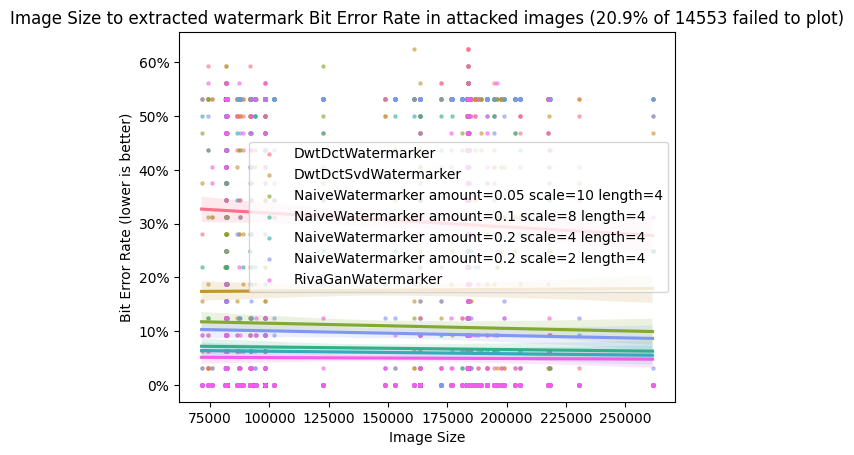

In [15]:
scatter_plot_for_each_attack(
    get_pixel_count,
    get_ber,
    "Image Size to extracted watermark Bit Error Rate in attacked images",
    "Image Size",
    "Bit Error Rate",
    y_lower_better=True,
    log_x_scale=False,
    log_y_scale=False,
    y_scale_percent=True,
    add_trendlines=True,
)

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(


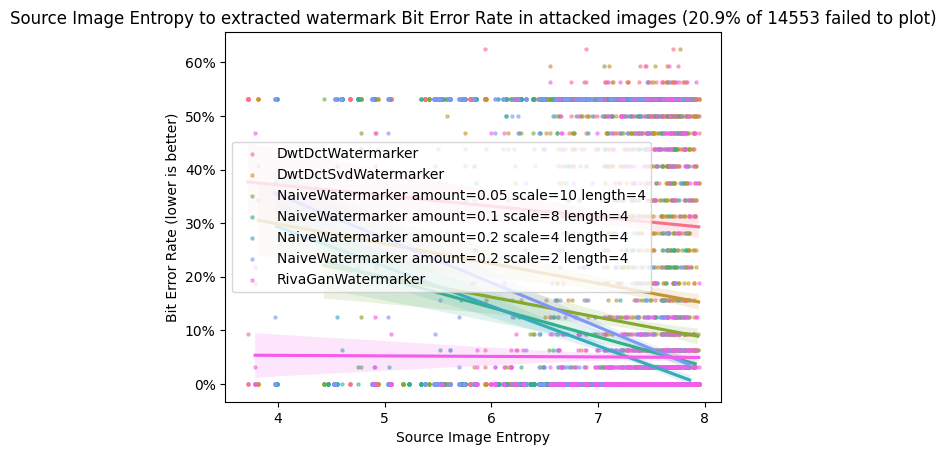

In [4]:
# plot entropy of source image vs bit error rate
scatter_plot_for_each_attack(
    get_source_image_entropy,
    get_ber,
    "Source Image Entropy to extracted watermark Bit Error Rate in attacked images",
    "Source Image Entropy",
    "Bit Error Rate",
    y_lower_better=True,
    log_x_scale=False,
    log_y_scale=False,
    y_scale_percent=True,
    add_trendlines=True,
)

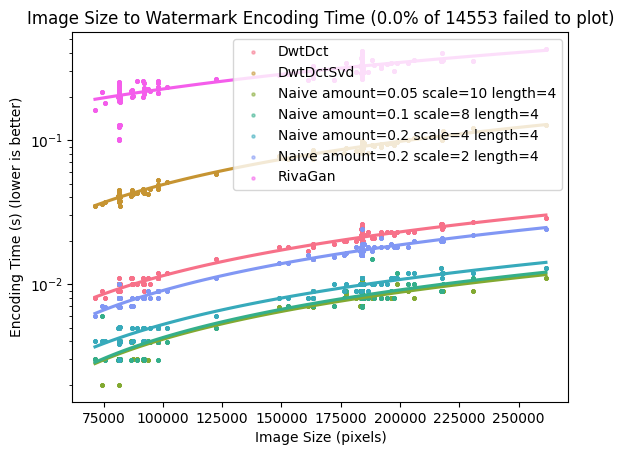

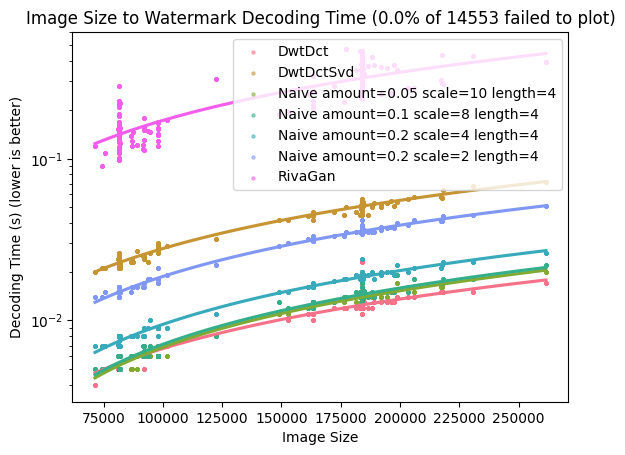

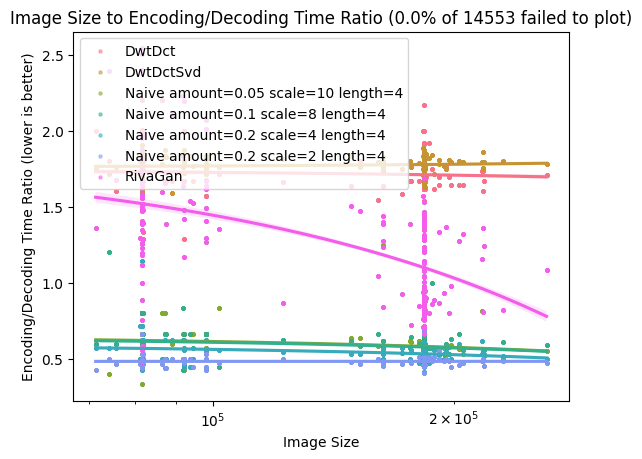

In [6]:
# plot pixel count vs encoding time
scatter_plot_for_each_attack(
    get_pixel_count,
    get_encoding_time,
    "Image Size to Watermark Encoding Time",
    "Image Size (pixels)",
    "Encoding Time (s)",
    y_lower_better=True,
    log_y_scale=True, 
    add_trendlines=True,
    disable_legend=True,
)

# plot pixel count vs decoding time
scatter_plot_for_each_attack(
    get_pixel_count,
    get_decoding_time,
    "Image Size to Watermark Decoding Time",
    "Image Size",
    "Decoding Time (s)",
    y_lower_better=True,
    log_y_scale=True,
    add_trendlines=True,
)

def get_encodinf_decoding_ratio(dto, watermark, attack):
    return watermark.encoding_time / watermark.decoding_results.decoding_time

# plot pixel count vs encoding/decoding time ratio
scatter_plot_for_each_attack(
    get_pixel_count,
    get_encodinf_decoding_ratio,
    "Image Size to Encoding/Decoding Time Ratio",
    "Image Size",
    "Encoding/Decoding Time Ratio",
    y_lower_better=True,
    log_y_scale=False,
    log_x_scale=True,
    add_trendlines=True,
)

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:207: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(
C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:211: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


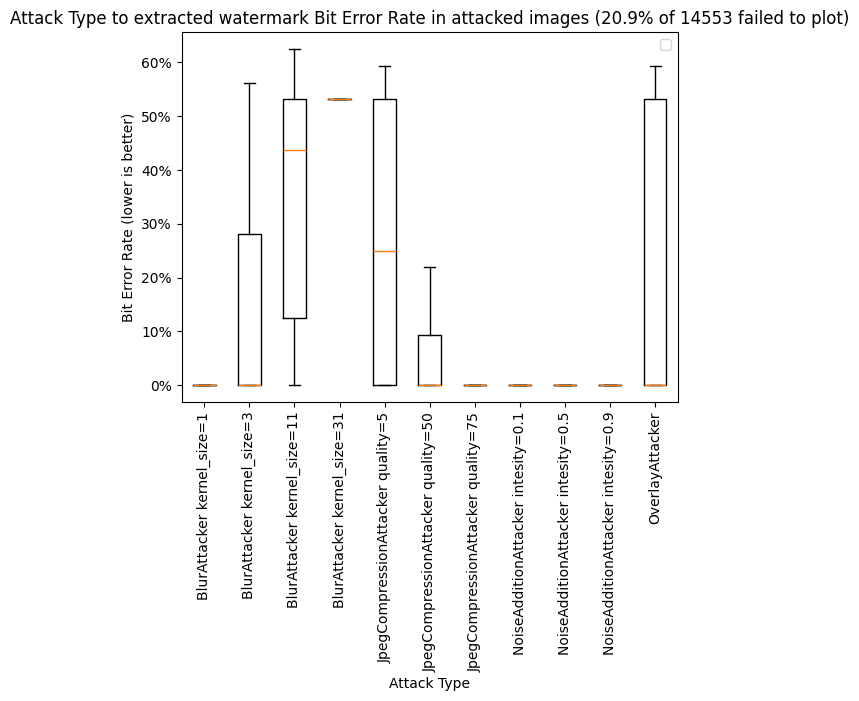

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:207: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(
C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:211: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


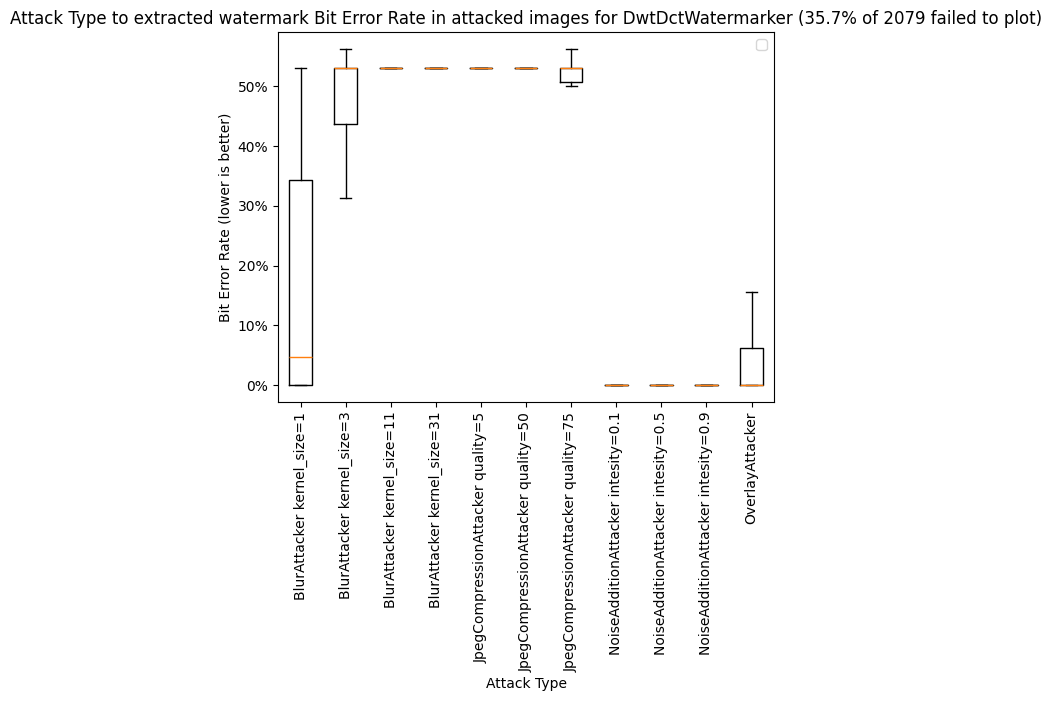

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:207: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(
C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:211: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


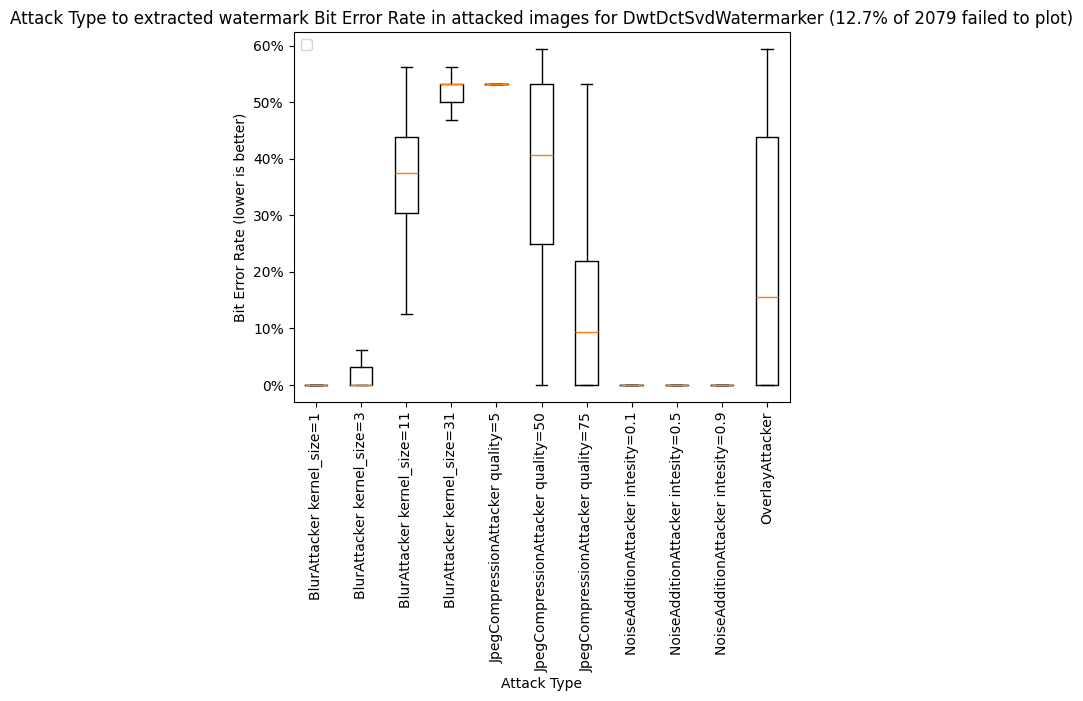

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:207: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(
C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:211: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


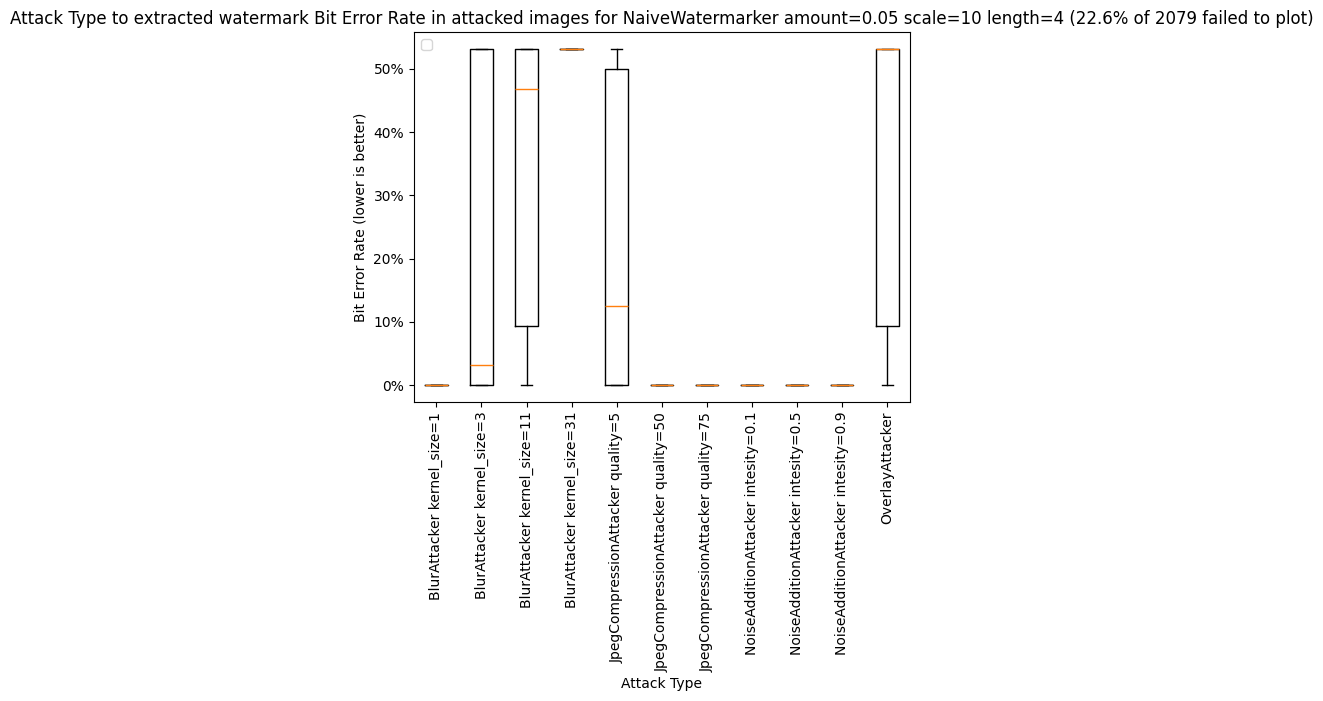

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:207: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(
C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:211: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


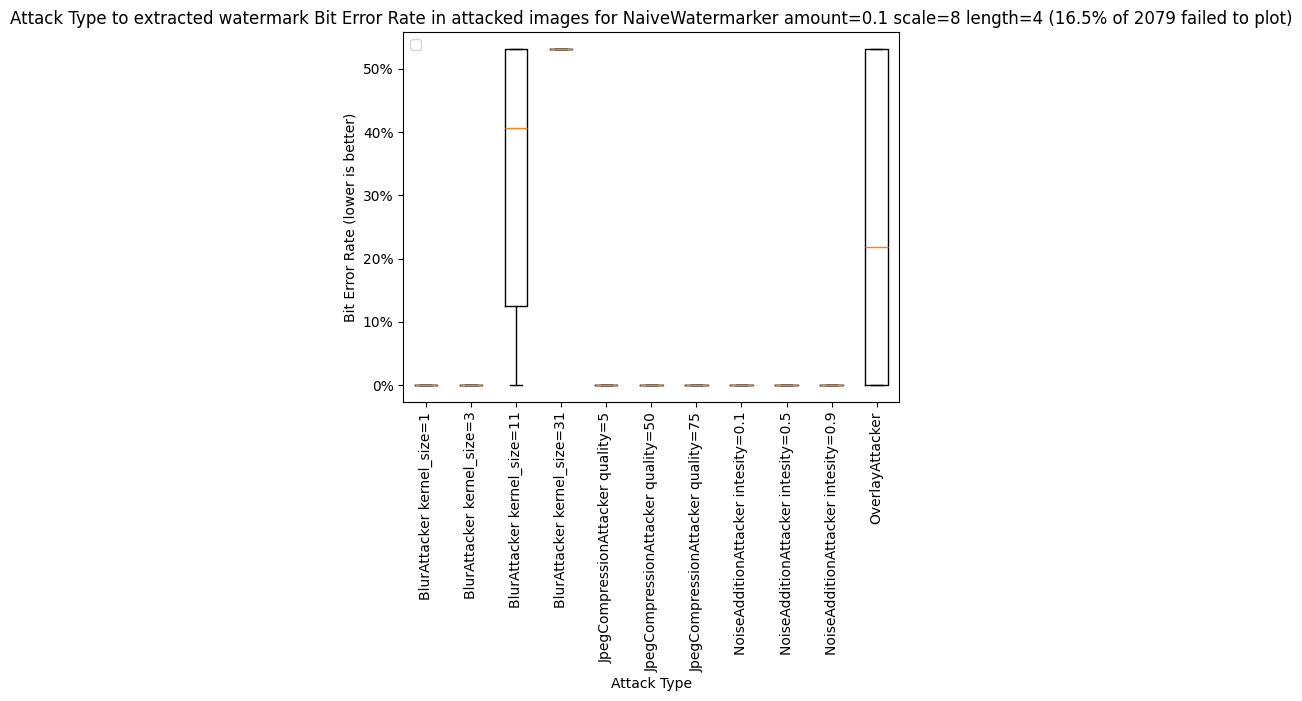

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:207: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(
C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:211: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


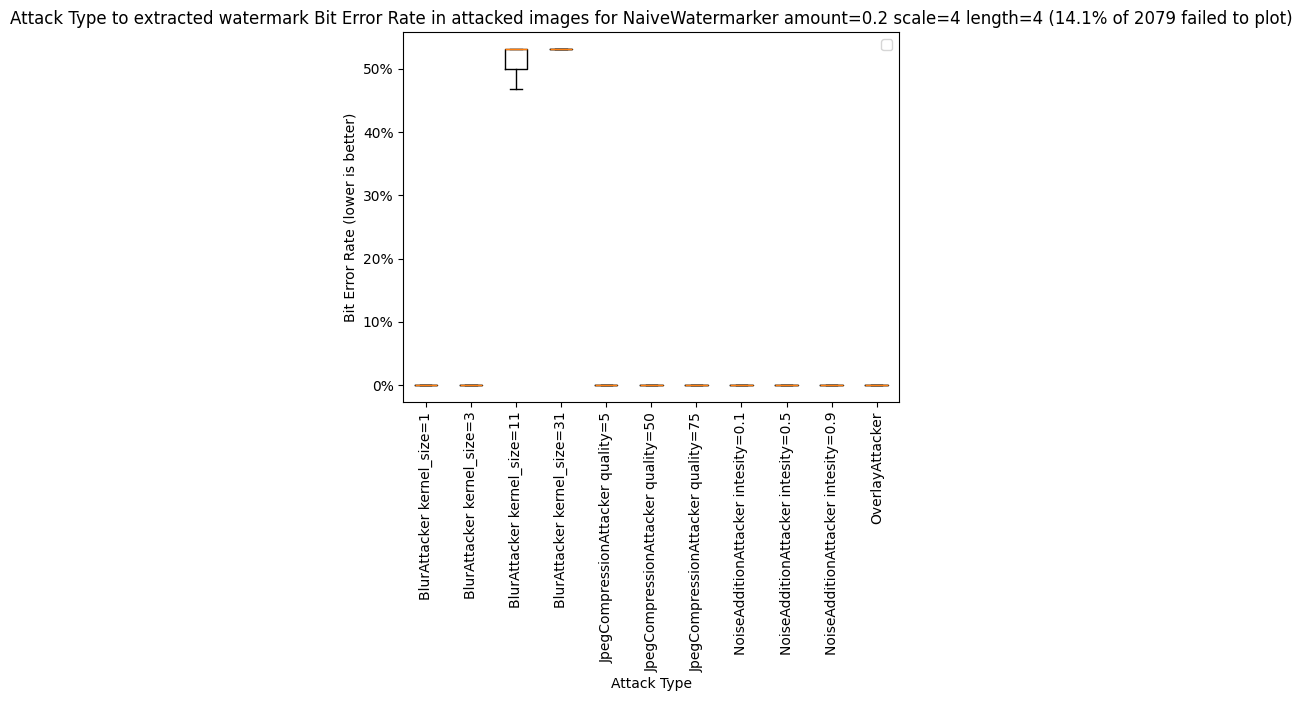

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:207: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(
C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:211: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


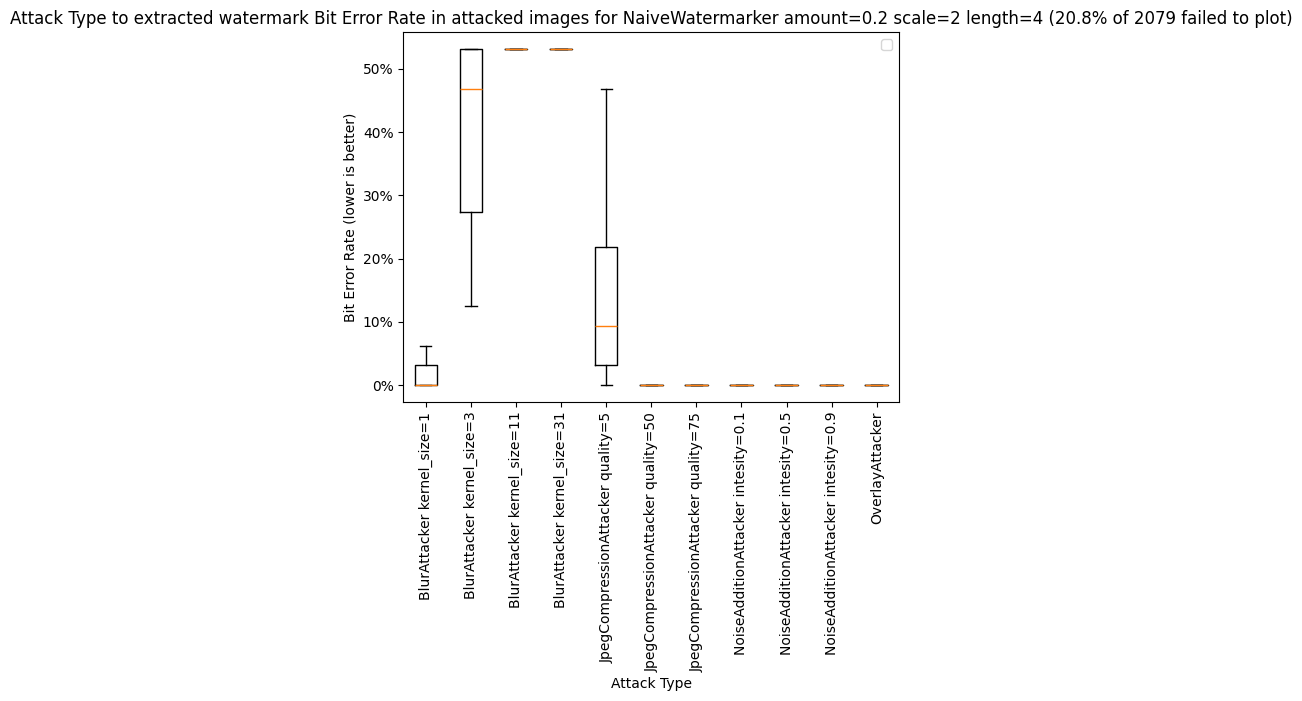

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:207: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(
C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:211: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


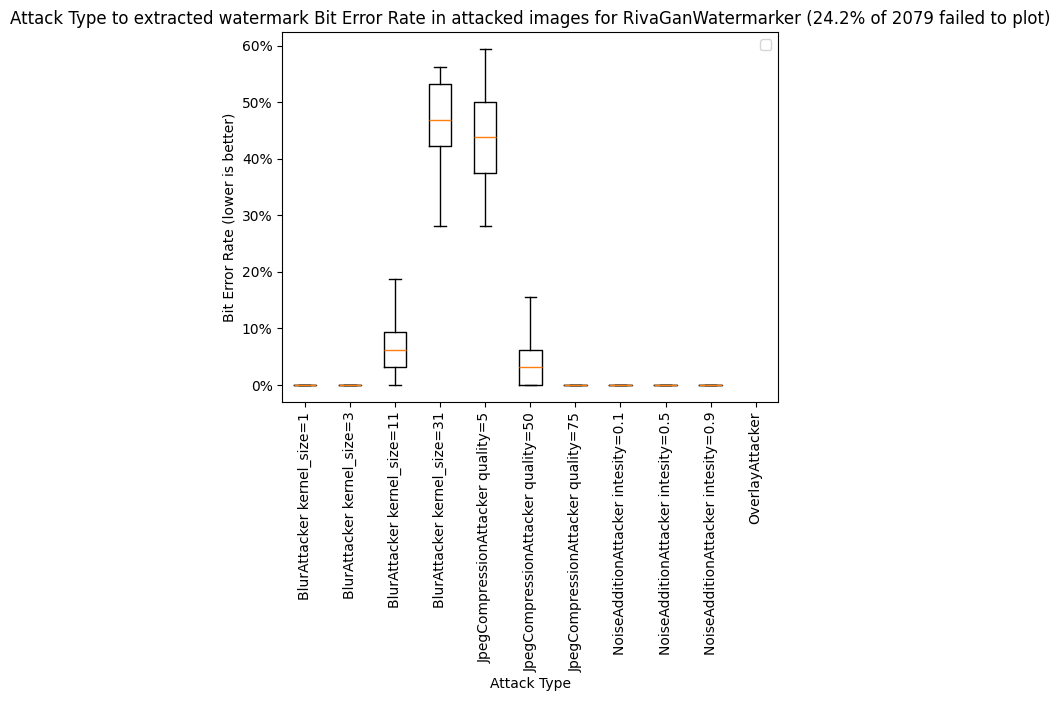

In [6]:
# plot attack type vs bit error rate
def get_attack_name(dto, watermark, attack):
    return attack.name

box_plot_for_each_attack(
    get_attack_name,
    get_ber,
    "Attack Type to extracted watermark Bit Error Rate in attacked images",
    "Attack Type",
    "Bit Error Rate",
    y_lower_better=True,
    y_scale_percent=True,
)

for watermark in data[0].watermarks:
    name = watermark.name
    func_pick_point = lambda dto, watermark, attack: watermark.name  == name
    box_plot_for_each_attack(
        get_attack_name,
        get_ber,
        f"Attack Type to extracted watermark Bit Error Rate in attacked images for {name}",
        "Attack Type",
        "Bit Error Rate",
        y_lower_better=True,
        y_scale_percent=True,
        func_pick_point=func_pick_point,
    )


In [7]:
# box plot attack type vs attacking time

# def get_attacking_time(dto, watermark, attack):
#     return attack.attacking_time

# box_plot_for_each_attack(
#     get_attack_name,
#     get_attacking_time,
#     "Attack Type to Attacking Time",
#     "Attack Type",
#     "Attacking Time (s)",
#     y_lower_better=True,
#     y_scale_percent=False,
# ) 

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:211: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


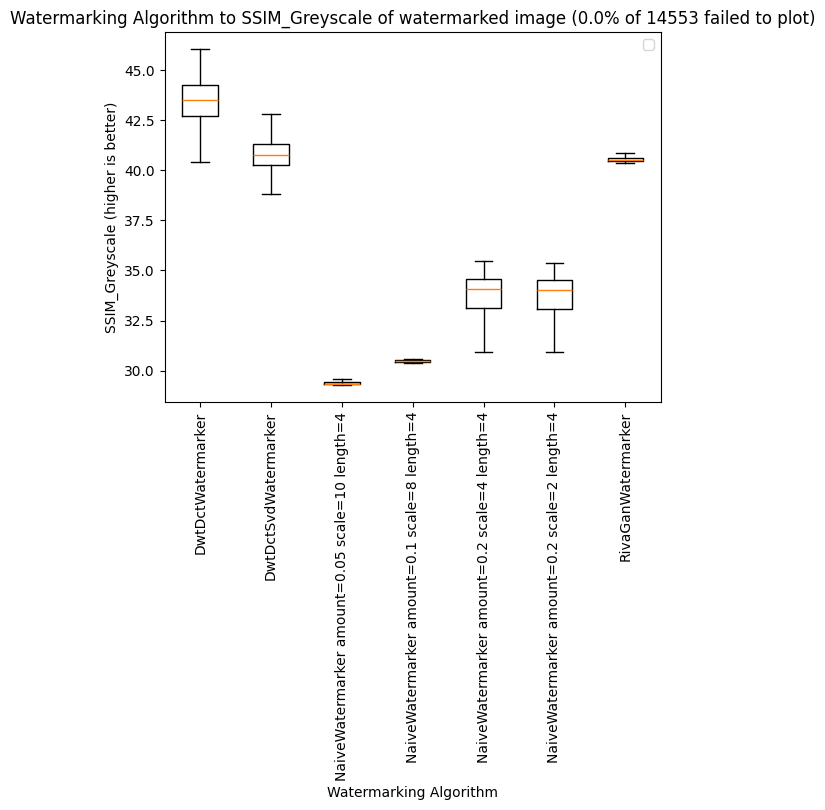

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:207: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(
C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:211: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


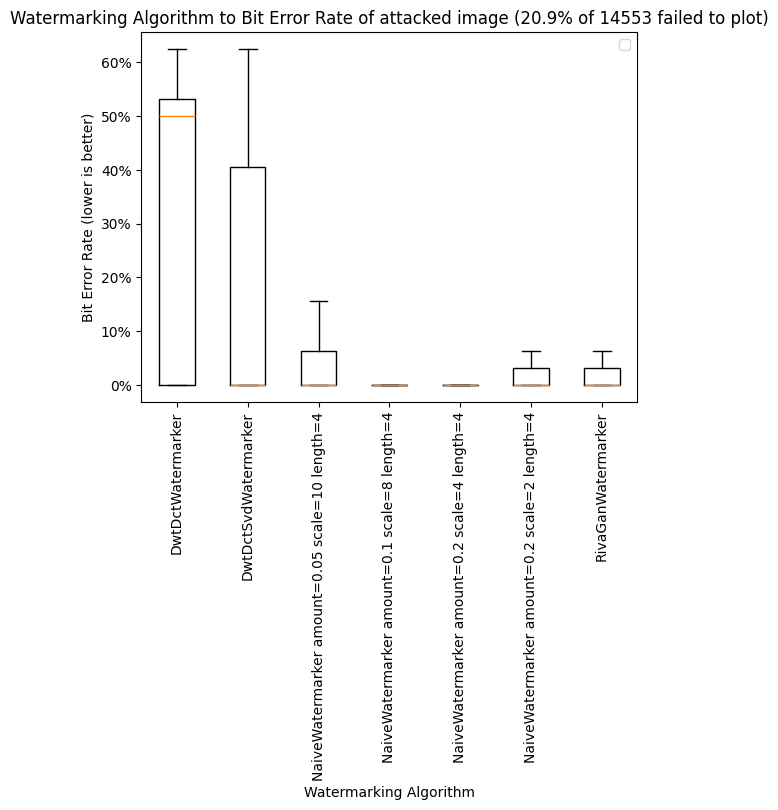

In [8]:
# boxplot PSNR of watermarked image vs waterarking algoirthm
def get_SSIM_Greyscale(dto, watermark, attack):
    return watermark.analysis_results.PSNR

def get_watermark_name(dto, watermark, attack):
    return watermark.name

def watermark_succeeded(dto, watermark, attack):
    return watermark.decoding_results is not None and watermark.decoding_results.extracted_watermark == dto.watermark

box_plot_for_each_attack(
    get_watermark_name,
    get_SSIM_Greyscale,
    "Watermarking Algorithm to SSIM_Greyscale of watermarked image",
    "Watermarking Algorithm",
    "SSIM_Greyscale",
    y_lower_better=False,
    y_scale_percent=False,
    # func_pick_point=watermark_succeeded,
)

# box plot ber of attacked image vs watermarking algorithm
def get_attacked_ber(dto, watermark, attack):
    return attack.decoding_results.decoding_metrics.Bit_Error_Rate

box_plot_for_each_attack(
    get_watermark_name,
    get_attacked_ber,
    "Watermarking Algorithm to Bit Error Rate of attacked image",
    "Watermarking Algorithm",
    "Bit Error Rate",
    y_lower_better=True,
    y_scale_percent=True,
    # default_error_y_value=0.5,
    # func_pick_point=watermark_succeeded,
)

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(


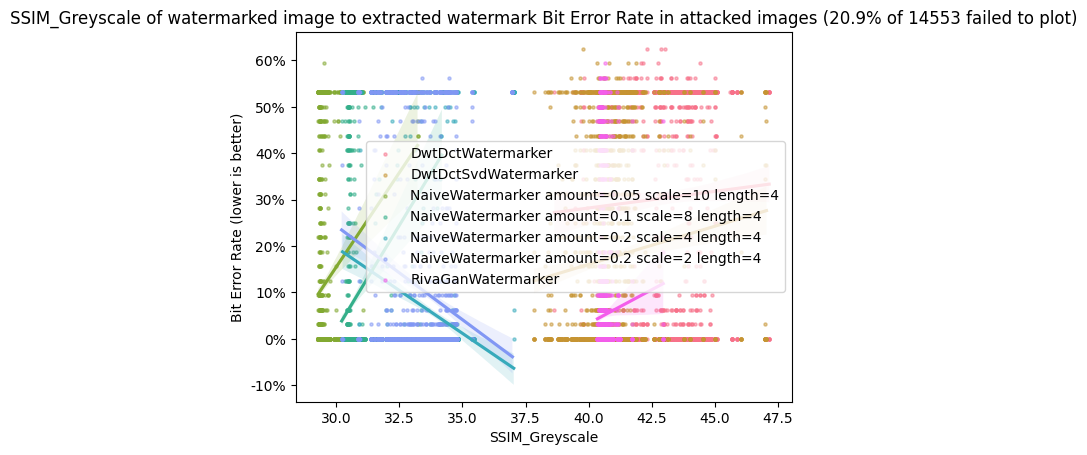

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(


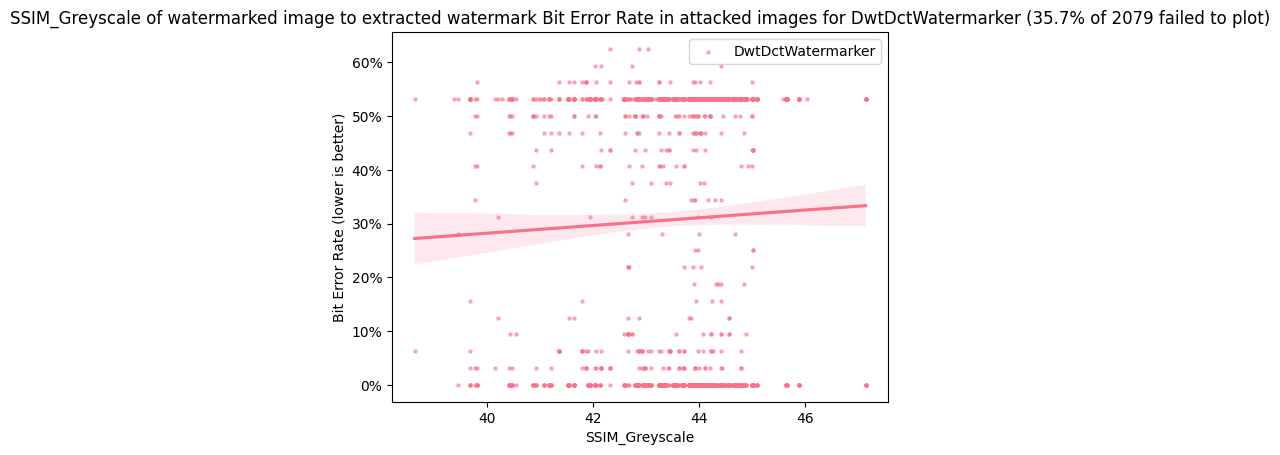

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(


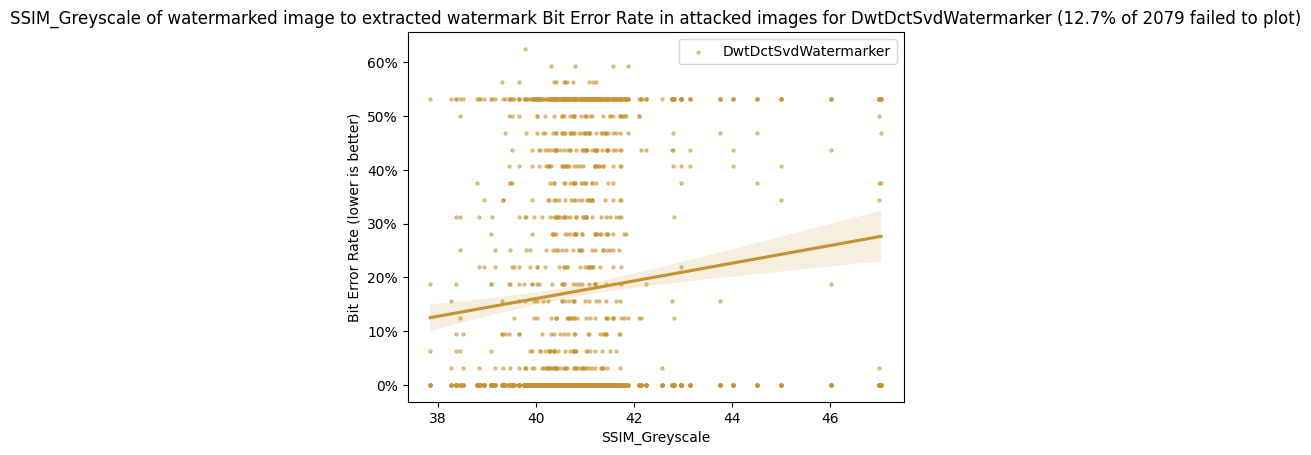

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(


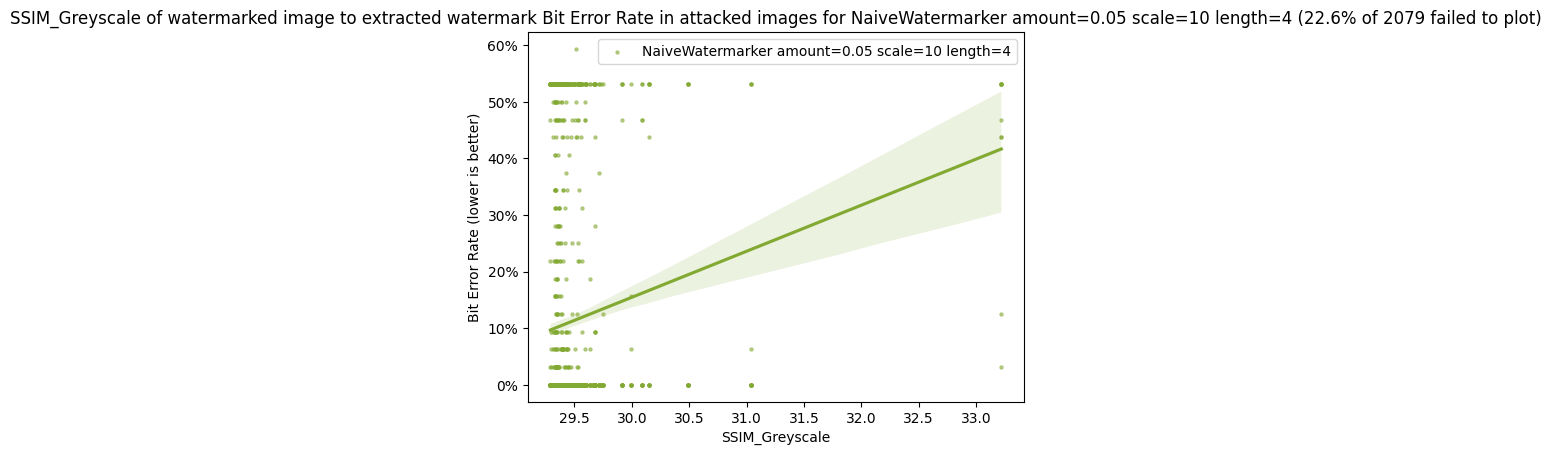

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(


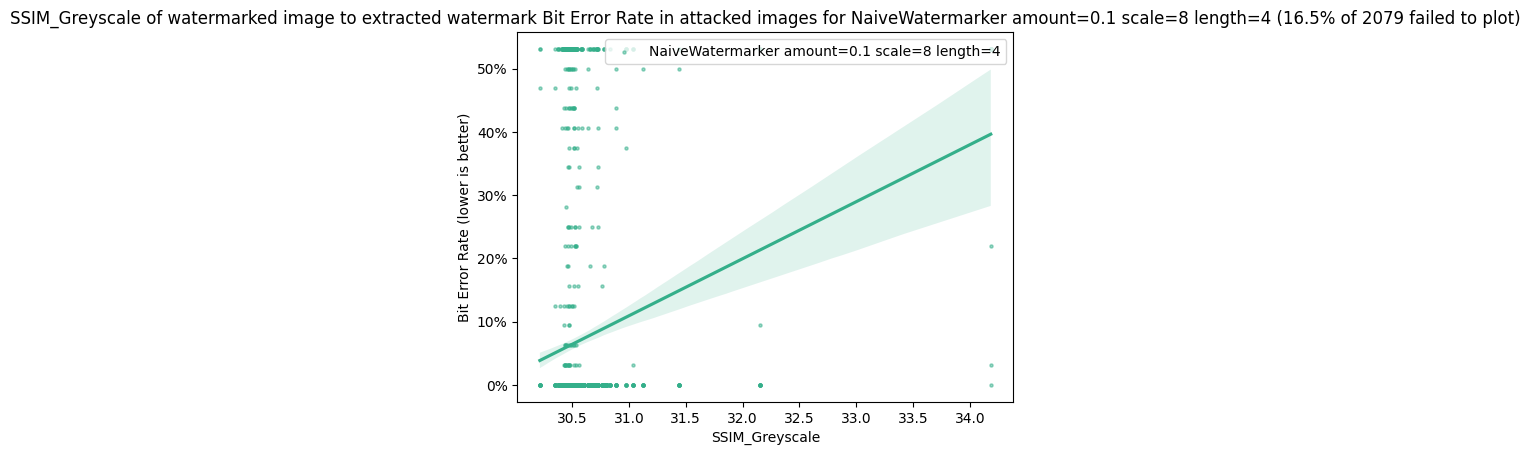

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(


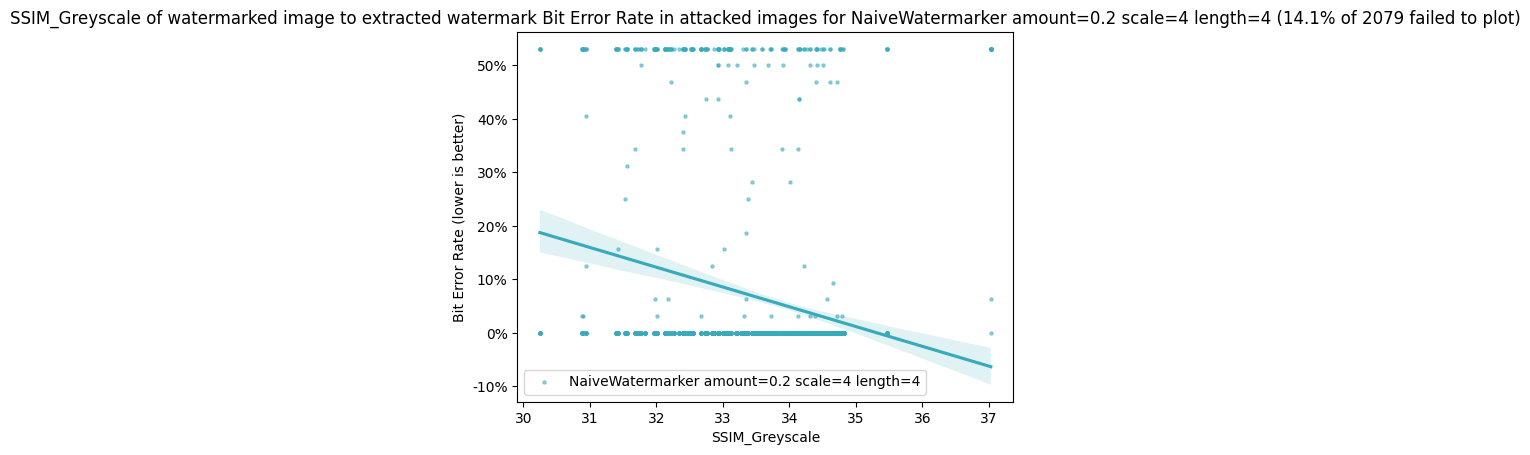

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(


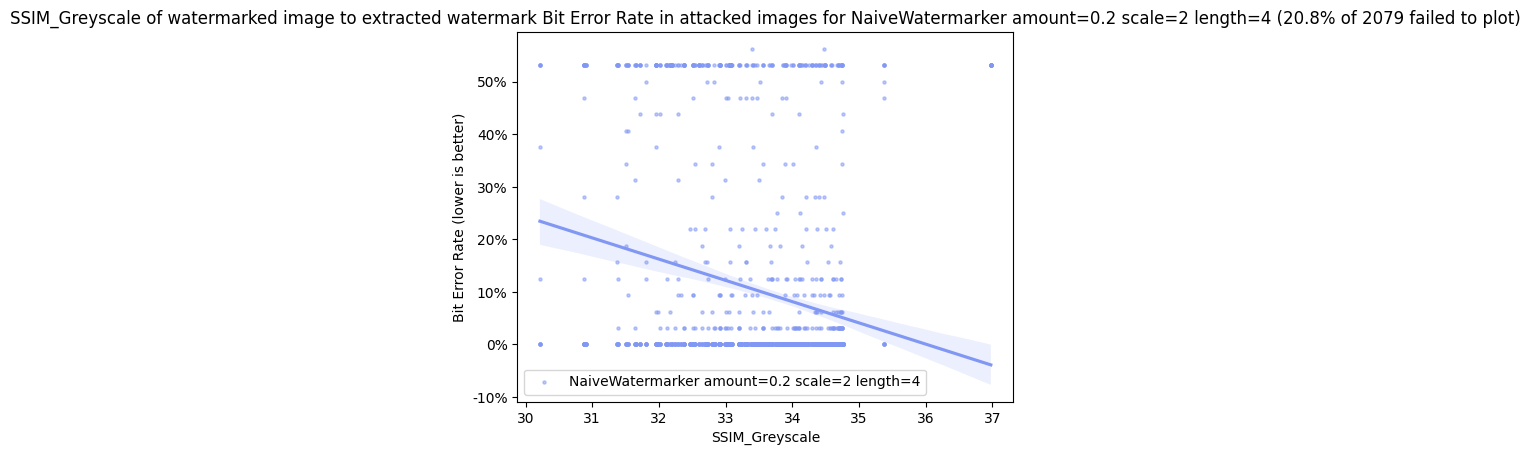

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(


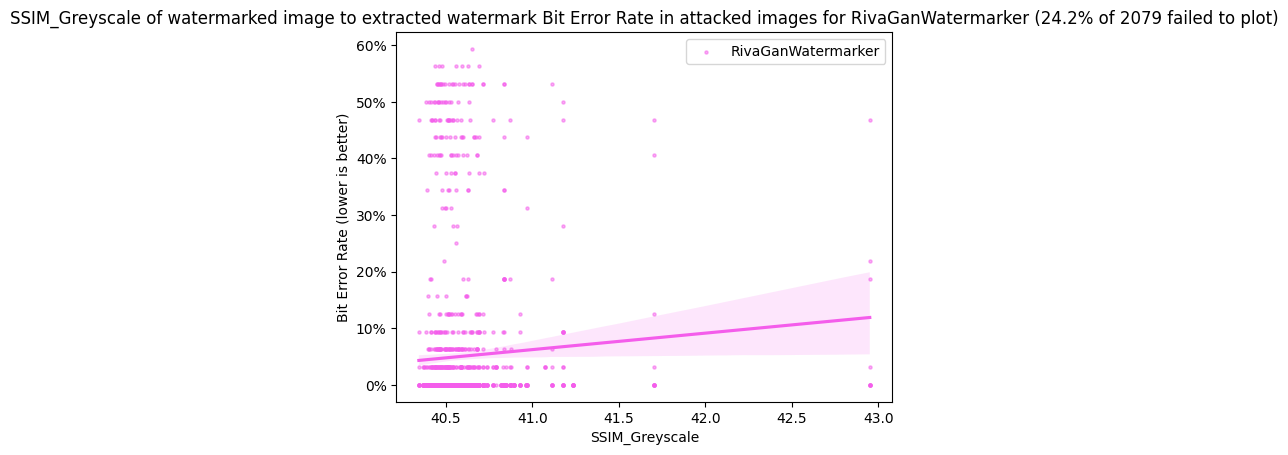

In [9]:
# plot sssim_grayscale of watermarked image vs BER
scatter_plot_for_each_attack(
    get_SSIM_Greyscale,
    get_ber,
    "SSIM_Greyscale of watermarked image to extracted watermark Bit Error Rate in attacked images",
    "SSIM_Greyscale",
    "Bit Error Rate",
    y_lower_better=True,
    log_x_scale=False,
    log_y_scale=False,
    y_scale_percent=True,
    add_trendlines=True,
)

for watermark in data[0].watermarks:
    name = watermark.name
    func_pick_point = lambda dto, watermark, attack: watermark.name  == name
    scatter_plot_for_each_attack(
        get_SSIM_Greyscale,
        get_ber,
        f"SSIM_Greyscale of watermarked image to extracted watermark Bit Error Rate in attacked images for {name}",
        "SSIM_Greyscale",
        "Bit Error Rate",
        y_lower_better=True,
        log_x_scale=False,
        log_y_scale=False,
        y_scale_percent=True,
        add_trendlines=True,
        func_pick_point=func_pick_point,
    )

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(


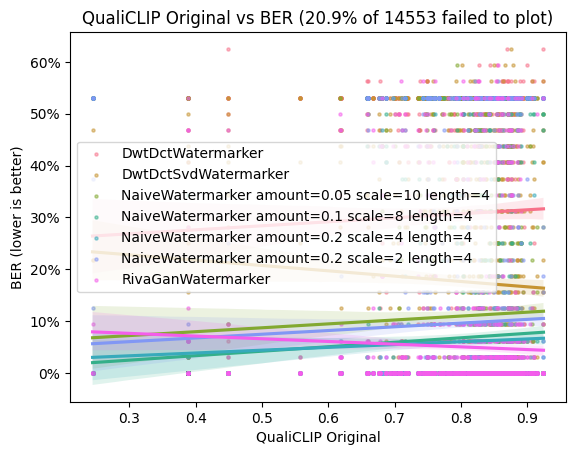

In [10]:
# plot qualiclips of watermarked vs BER
def get_qualiclips_original(dto, watermark, attack):
    return watermark.analysis_results.QualiCLIP_original

scatter_plot_for_each_attack(
    get_qualiclips_original,
    get_ber,
    "QualiCLIP Original vs BER",
    "QualiCLIP Original",
    "BER",
    y_lower_better=True,
    log_x_scale=False,
    log_y_scale=False,
    y_scale_percent=True,
    add_trendlines=True,
)

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:207: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(
C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:211: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


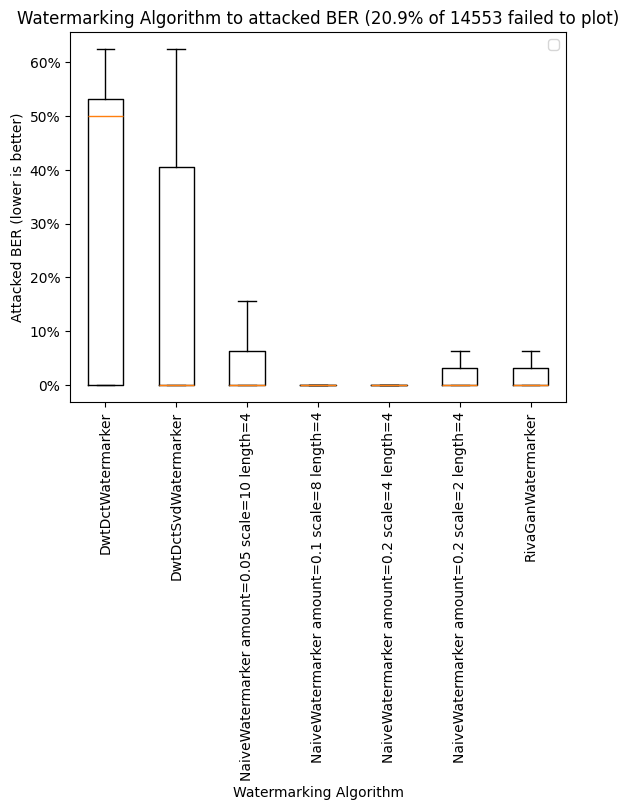

In [11]:
# algorithm type to attacked BER
def get_algorithm_name(dto, watermark, attack):
    return watermark.name

def get_attacked_ber(dto, watermark, attack):
    return attack.decoding_results.decoding_metrics.Bit_Error_Rate

box_plot_for_each_attack(
    get_algorithm_name,
    get_attacked_ber,
    "Watermarking Algorithm to attacked BER",
    "Watermarking Algorithm",
    "Attacked BER",
    y_lower_better=True,
    y_scale_percent=True,
)

Watermarking algorithm DwtDctWatermarker succeeded 91 out of 189 times (48.15%)
Watermarking algorithm DwtDctSvdWatermarker succeeded 189 out of 189 times (100.00%)
Watermarking algorithm NaiveWatermarker amount=0.05 scale=10 length=4 succeeded 188 out of 189 times (99.47%)
Watermarking algorithm NaiveWatermarker amount=0.1 scale=8 length=4 succeeded 188 out of 189 times (99.47%)
Watermarking algorithm NaiveWatermarker amount=0.2 scale=4 length=4 succeeded 188 out of 189 times (99.47%)
Watermarking algorithm NaiveWatermarker amount=0.2 scale=2 length=4 succeeded 188 out of 189 times (99.47%)
Watermarking algorithm RivaGanWatermarker succeeded 183 out of 189 times (96.83%)


C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\1870309166.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(


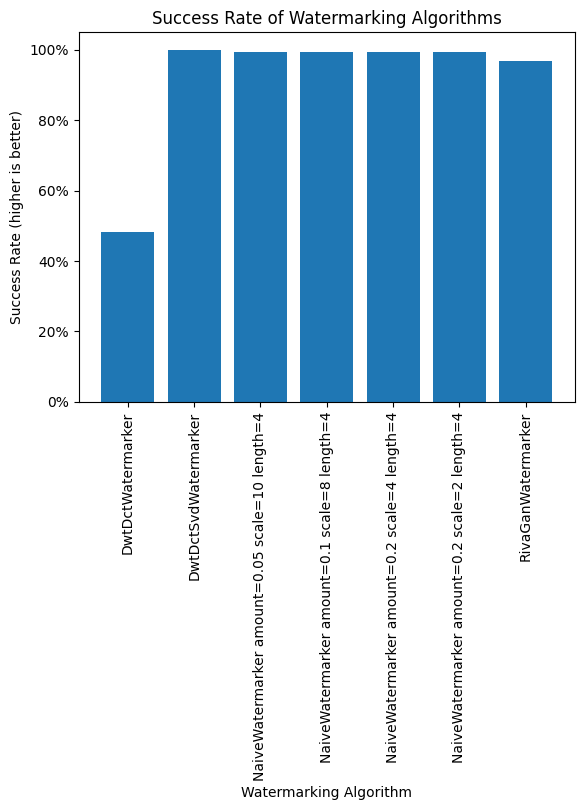

In [12]:
# calulate how many basic watermarking succede for every image
succeeded = {}
total = {}
for dto in data:
    for watermark in dto.watermarks:
        if watermark.name not in succeeded:
            succeeded[watermark.name] = 0
            total[watermark.name] = 0
        try:
            if watermark.decoding_results.decoded_watermark == dto.watermark:
                succeeded[watermark.name] += 1
        except Exception as e:
            print(f"Failed to get data for {watermark.name}: {e}")
        total[watermark.name] += 1

success_rate = {}
for watermark in succeeded:
    success_rate[watermark] = succeeded[watermark] / total[watermark]
for watermark in succeeded:
    print(f"Watermarking algorithm {watermark} succeeded {succeeded[watermark]} out of {total[watermark]} times ({succeeded[watermark]/total[watermark]*100:.2f}%)")

# plot how many times each attack succeded using success rate
plt.figure()
plt.bar(success_rate.keys(), success_rate.values())
plt.xlabel("Watermarking Algorithm")
plt.ylabel("Success Rate (higher is better)")
plt.title("Success Rate of Watermarking Algorithms")
plt.xticks(rotation=90)
plt.gca().set_yticklabels(
    ["{:.0f}%".format(y * 100) for y in plt.gca().get_yticks()]
)
plt.show()

Watermarking algorithm DwtDctWatermarker succeeded 364 out of 1001 times (36.36%)
Watermarking algorithm DwtDctSvdWatermarker succeeded 956 out of 2079 times (45.98%)
Watermarking algorithm NaiveWatermarker amount=0.05 scale=10 length=4 succeeded 1162 out of 2068 times (56.19%)
Watermarking algorithm NaiveWatermarker amount=0.1 scale=8 length=4 succeeded 1452 out of 2068 times (70.21%)
Watermarking algorithm NaiveWatermarker amount=0.2 scale=4 length=4 succeeded 1553 out of 2068 times (75.10%)
Watermarking algorithm NaiveWatermarker amount=0.2 scale=2 length=4 succeeded 1183 out of 2068 times (57.21%)
Watermarking algorithm RivaGanWatermarker succeeded 1177 out of 2013 times (58.47%)


C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\306685130.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(


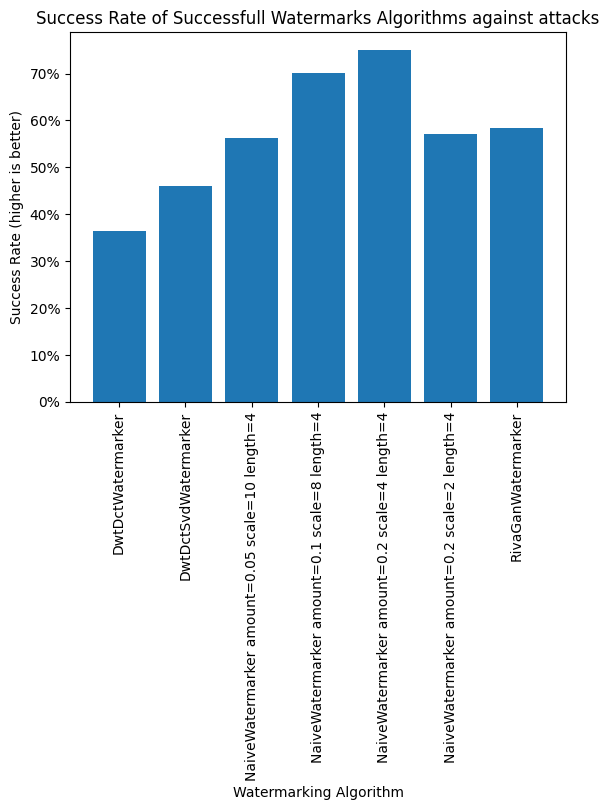

In [13]:
# plot when watermark succeded and attacking failed
# watermark.decoding_results is not None and watermark.decoding_results.decoded_watermark == dto.watermark
succeeded = {}
total = {}

for dto in data:
    for watermark in dto.watermarks:
        if watermark.name not in succeeded:
            succeeded[watermark.name] = 0
            total[watermark.name] = 0
        try:
            if watermark.decoding_results is None or watermark.decoding_results.decoded_watermark != dto.watermark: # watermarking failed
                continue
            for attack in watermark.attacks:
                if attack.decoding_results is not None and attack.decoding_results.decoded_watermark == dto.watermark:
                    succeeded[watermark.name] += 1
                total[watermark.name] += 1
        except Exception as e:
            print(f"Failed to get data for {watermark.name}: {e}")
    
success_rate = {}
for watermark in succeeded:
    success_rate[watermark] = succeeded[watermark] / total[watermark]
for watermark in succeeded:
    print(f"Watermarking algorithm {watermark} succeeded {succeeded[watermark]} out of {total[watermark]} times ({success_rate[watermark]*100:.2f}%)")

# plot how many times each attack succeded using success rate
plt.figure()
plt.bar(success_rate.keys(), success_rate.values())
plt.xlabel("Watermarking Algorithm")
plt.ylabel("Success Rate (higher is better)")
plt.title("Success Rate of Successfull Watermarks Algorithms against attacks")
plt.xticks(rotation=90)
plt.gca().set_yticklabels(
    ["{:.0f}%".format(y * 100) for y in plt.gca().get_yticks()]
)
plt.show()


C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(


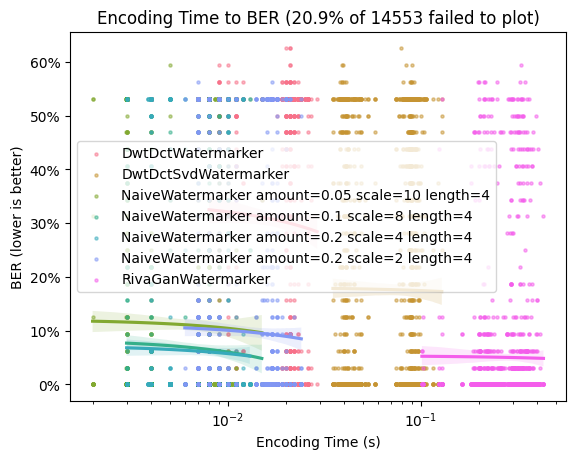

C:\Users\Vectro\AppData\Local\Temp\ipykernel_41212\231901627.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(


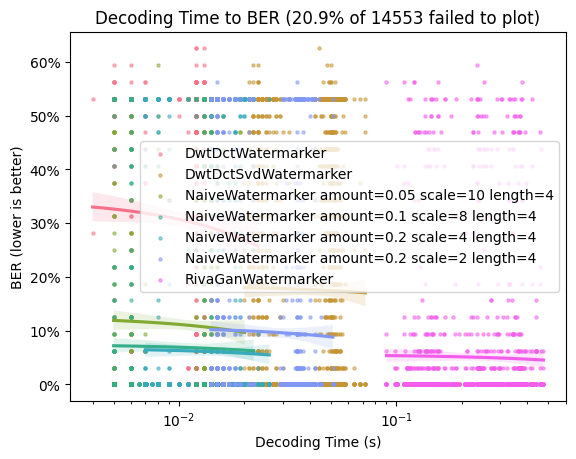

In [14]:
# plot encoding time to BER
scatter_plot_for_each_attack(
    get_encoding_time,
    get_ber,
    "Encoding Time to BER",
    "Encoding Time (s)",
    "BER",
    y_lower_better=True,
    log_x_scale=True,
    log_y_scale=False,
    y_scale_percent=True,
    add_trendlines=True,
)

# plot decoding time to BER
scatter_plot_for_each_attack(
    get_decoding_time,
    get_ber,
    "Decoding Time to BER",
    "Decoding Time (s)",
    "BER",
    y_lower_better=True,
    log_x_scale=True,
    log_y_scale=False,
    y_scale_percent=True,
    add_trendlines=True,
)